# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [3]:
# --- Extension Setup ---
%reload_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
import afml

# Check if auto-reload is available
print(f"Auto-reload available: {afml.AUTO_RELOAD_AVAILABLE}")

# Setup with auto-reload enabled
app = afml.setup_jupyter(enable_auto_reload=True)

# # --- Logging (Optional but Recommended) ---
# from loguru import logger
# from pathlib import Path

# # Optional: clear old logs
# log_path = Path("logs") / "afml_session.log"
# log_path.parent.mkdir(exist_ok=True)
# log_path.unlink(missing_ok=True)

# # Configure Loguru
# logger.add(log_path, level="INFO", rotation="10 MB", retention="10 days")
# logger.info("Session started")

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


2025-10-23 01:30:19.611 | DEBUG    | afml.cache:<module>:344 - Auto-reload functionality available
2025-10-23 01:30:19.613 | DEBUG    | afml.cache:_configure_numba:61 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-10-23 01:30:19.614 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-10-23 01:30:19.618 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-10-23 01:30:19.620 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-10-23 01:30:19.623 | INFO     | afml.cache:initialize_cache_system:318 -   Loaded stats: 4 functions, 37.8% hit rate
2025-10-23 01:30:26.917 | DEBUG    | afml.cache.selective_cleaner:_load_tracking_data:39 - Loaded tracking data for 17 functions
2025-10-23 01:30:33.505 | DEBUG    | afml:<module>:91 - Imported lightweight modules direct

Auto-reload available: True
Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [4]:
import warnings
import winsound
from datetime import datetime as dt
from datetime import timedelta
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import talib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, recall_score
from sklearn.base import clone

from afml.backtest_statistics import calculate_performance_metrics
from afml.bet_sizing.bet_sizing import (
    bet_size_budget,
    bet_size_probability,
    bet_size_reserve,
)
from afml.cache import cache_maintenance, clear_afml_cache, selective_cache_clear
from afml.cross_validation.cross_validation import (
    PurgedKFold,
    PurgedSplit,
    ml_cross_val_score,
    ml_cross_val_scores_all,
    best_weighting_by_mean_score,
)
from afml.cross_validation.scoring import probability_weighted_accuracy
from afml.data_structures.bars import make_bars, calculate_ticks_per_period
from afml.features import get_fractal_features, get_time_features, is_stationary
from afml.filters import cusum_filter, z_score_filter
from afml.labeling import (
    add_vertical_barrier,
    drop_labels,
    get_event_weights,
    get_events,
    trend_scanning_labels,
    triple_barrier_labels,
)
from afml.mt5.load_data import (
    clean_tick_data,
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
)
from afml.sample_weights.optimized_attribution import (
    get_weights_by_time_decay_optimized,
)
from afml.sampling import (
    SequentiallyBootstrappedBaggingClassifier,
    get_ind_mat_average_uniqueness,
    get_ind_matrix,
    seq_bootstrap,
    precompute_active_indices,
)
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
    plot_bbands,
    plot_bbands_dual_bbp_bw,
)
from afml.util import (
    CLEAN_DATA_PATH,
    COMMODITIES,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    GREEKS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    get_period_vol,
    smart_subscript,
    to_subscript,
    value_counts_data,
)

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [5]:
# clear_afml_cache()
pprint(cache_maintenance(), sort_dicts=False)

2025-10-23 01:30:39.998 | INFO     | afml.cache.selective_cleaner:selective_cache_clear:274 - No function changes detected
2025-10-23 01:30:40.125 | INFO     | afml.cache.selective_cleaner:cache_maintenance:425 - Cache maintenance completed: 10 functions checked


{'functions_checked': 10,
 'changed_functions': [],
 'cleared_functions': [],
 'size_cleared_mb': 0,
 'old_files_removed': 0}


## 1. Data Preparation

In [6]:
account = "FundedNext_STLR2_6K"

# Your transaction cost constants
COST_PER_ROUND_LOT = 3.00
UNITS_PER_LOT = 100000
COST_PER_UNIT = COST_PER_ROUND_LOT / UNITS_PER_LOT

# account = "METAQUOTES_DEMO_25K"
# account = login_mt5(account)
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2022-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date
login_mt5(account)

2025-10-23 01:30:40.804 | INFO     | afml.mt5.load_data:login_mt5:83 - Attempting to log in to MT5 with account: FundedNext_STLR2_6K
2025-10-23 01:30:49.561 | SUCCESS  | afml.mt5.load_data:login_mt5:94 - Successfully logged in to MT5 as FundedNext_STLR2_6K.
2025-10-23 01:30:49.566 | INFO     | afml.mt5.load_data:login_mt5:96 - MT5 Version: (500, 5370, '17 Oct 2025')
2025-10-23 01:30:49.574 | INFO     | afml.mt5.load_data:login_mt5:99 - Connected to MetaTrader 5 at C:\Program Files\MetaTrader 5


'FundedNext_STLR2_6K'

In [7]:
def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict.get(timeframe)
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
            print(f"Loading ticks from {CLEAN_DATA_PATH}...")
        except FileNotFoundError:
            print(f"Downloading ticks to {DATA_PATH}...")
            save_data_to_parquet(DATA_PATH, symbol, start_date, end_date, account)
            tick_df = load_tick_data(DATA_PATH, symbol, start_date, end_date, account, columns)
            tick_df = clean_tick_data(tick_df)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

In [8]:
# eur_usd = get_ticks(symbol, sample_start, sample_end)
# save_data_to_parquet("../data", "XAUUSD", start_date, end_date, account)      

In [9]:
# xauusd = load_tick_data("../data", "XAUUSD", sample_start, sample_end, account, columns)
# xauusd_clean = clean_tick_data(xauusd)

## 2. Bollinger Band Strategy

In [10]:
bb_timeframe = "M5"
tick_bar_size = tick_bar_dict.get(bb_timeframe)
print(f"{bb_timeframe} = tick-{tick_bar_size}")
bb_time_bars, bb_tick_bars = get_data(symbol, bb_timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"

M5 = tick-200
Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


In [20]:
bb_period, bb_std = 20, 2 # Bollinger Band parameters
bb_strategy = BollingerStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier = (1, 2)
bb_time_horizon = dict(hours=4)
min_ret = 0.0
bb_vol_multiplier = 1

### Time-Bars

In [23]:
bb_side = bb_strategy.generate_signals(bb_time_bars)
bb_df = bb_time_bars.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = bb_period
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close
_, t_events = get_entries(bb_strategy, bb_df, filter_threshold=vol_target.mean())

vertical_barriers = add_vertical_barrier(t_events, close, **bb_time_horizon)

Bollinger_w20_std2 Signals:

        count  proportion
side                     
 0    310,455    0.840146
-1     29,598    0.080097
 1     29,472    0.079756



2025-10-23 01:36:38.757 | INFO     | afml.filters.filters:cusum_filter:151 - 40,787 CUSUM-filtered events
2025-10-23 01:36:38.967 | INFO     | afml.strategies.signal_processing:get_entries:105 - Bollinger_w20_std2 | 14,459 (24.48%) trade events selected by CUSUM filter (threshold = 0.0696%).


#### Feature Engineering

In [13]:
bb_feat = create_bollinger_features(bb_time_bars, bb_period, bb_std)
bb_feat_time = bb_feat.copy()
bb_feat_time.info()
# not_stationary = is_stationary(bb_feat_time)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516825 entries, 2018-01-02 23:20:00 to 2024-12-31 00:00:00
Data columns (total 63 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   close                516825 non-null  float32
 1   spread               516825 non-null  float32
 2   vol                  516825 non-null  float32
 3   h1_vol               516825 non-null  float32
 4   h4_vol               516825 non-null  float32
 5   d1_vol               516825 non-null  float32
 6   ret                  516825 non-null  float32
 7   ret_5                516825 non-null  float32
 8   ret_10               516825 non-null  float32
 9   ret_1_lag_1          516825 non-null  float32
 10  ret_5_lag_1          516825 non-null  float32
 11  ret_10_lag_1         516825 non-null  float32
 12  ret_1_lag_2          516825 non-null  float32
 13  ret_5_lag_2          516825 non-null  float32
 14  ret_10_lag_2         516825 non-nu

#### Triple-Barrier Method

In [24]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)

bb_events_tb_time = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb.bin, verbose=True)

weights = get_event_weights(bb_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h={'hours': 4}):

     count  proportion
bin                   
1    8,210    0.568284
0    6,237    0.431716

Average Uniqueness: 0.7523


#### Cross-Validation of Weighting Methods

In [49]:
# Real-world example with financial data preparation
def prepare_financial_data(price_data, features, labels):
    """
    price_data: DataFrame with price information
    features: DataFrame with feature columns
    labels: Series with target labels from triple barrier method
    samples_info_sets: Series with t1 values from get_events()
    """
    
    # Ensure all indices are aligned
    common_index = price_data.index.intersection(features.index).intersection(labels.index)
    
    X = features.loc[common_index]
    y = labels.loc[common_index, 'bin']
    
    # Assuming you have samples_info_sets from triple barrier labeling
    samples_info_sets = labels.loc[common_index, 't1']  # Your t1 series from get_events()
    price_bars_index = price_data.index
    
    return X, y, samples_info_sets, price_bars_index

# Example usage with real financial data:
"""
# Assuming you have:
# - price_data: OHLCV data
# - features: technical indicators/features
# - events: output from get_events() (triple barrier labeling)

from mlfinlab.labeling import get_events

# Generate triple barrier events
triple_barrier_events = get_events(
    close=price_data['close'],
    t_events=some_trigger_events,  # Your entry signals
    pt_sl=[1.0, 1.0],  # Profit take / stop loss
    target=volatility_estimates,  # Your volatility estimates
    min_ret=0.005,  # Minimum return
    num_threads=1,
    vertical_barrier_times=vertical_barriers  # Optional
)

# Get labels and samples_info_sets
labels = triple_barrier_events['bin']
samples_info_sets = triple_barrier_events['t1']

# Prepare data
X, y, samples_info_sets, price_bars_index = prepare_financial_data(
    price_data, features, labels
)

# Then proceed with the cross-validation as shown above
"""

"\n# Assuming you have:\n# - price_data: OHLCV data\n# - features: technical indicators/features\n# - events: output from get_events() (triple barrier labeling)\n\nfrom mlfinlab.labeling import get_events\n\n# Generate triple barrier events\ntriple_barrier_events = get_events(\n    close=price_data['close'],\n    t_events=some_trigger_events,  # Your entry signals\n    pt_sl=[1.0, 1.0],  # Profit take / stop loss\n    target=volatility_estimates,  # Your volatility estimates\n    min_ret=0.005,  # Minimum return\n    num_threads=1,\n    vertical_barrier_times=vertical_barriers  # Optional\n)\n\n# Get labels and samples_info_sets\nlabels = triple_barrier_events['bin']\nsamples_info_sets = triple_barrier_events['t1']\n\n# Prepare data\nX, y, samples_info_sets, price_bars_index = prepare_financial_data(\n    price_data, features, labels\n)\n\n# Then proceed with the cross-validation as shown above\n"

In [50]:
X, y, t1, price_bars_index = prepare_financial_data(bb_df.close, features=bb_feat_time, labels=bb_events_tb_time)
cont = bb_events_tb_time.loc[X.index]

test_size = 0.25
n_splits = 3
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

cont_train = get_event_weights(cont.iloc[train], bb_df.close.loc[price_bars_index])
cont_train_bb = cont_train.copy()

In [51]:
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }


decay_factors = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    decay=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v
    # if k.startswith('exp'):
    #     weighting_schemes[k.replace('exp_', '')] = v.iloc[train]

weighting_schemes.keys()

dict_keys(['unweighted', 'uniqueness', 'return'])

In [27]:
random_state = 42
min_w_leaf = 0.05

clf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    max_samples=cont_train.tW.mean(),
    n_jobs=-1,  # Use all available cores
    )

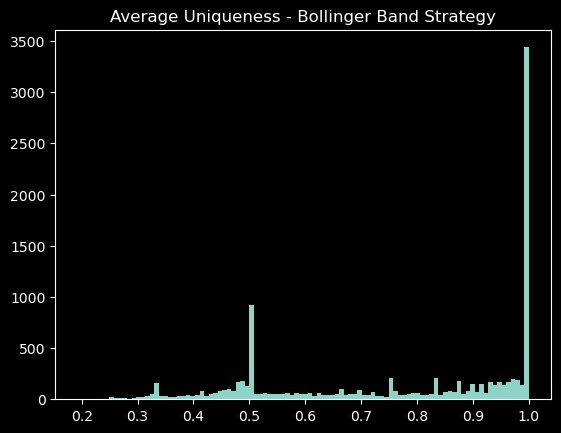

In [28]:
cont_train["tW"].hist(bins=100, grid=False)
plt.title("Average Uniqueness - Bollinger Band Strategy");

In [33]:
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
cv_scores_d = {}
print(clf.__class__.__name__, "Weighting Schemes")

best_scheme = None
scoring = f1_score
print(f"{scoring.__name__}:")

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    if scheme.startswith(('linear_time_decay', 'exp_time_decay')):
        if 'exp_time_decay' in scheme:
            continue
        if best_scheme is None:
            best_scheme, best_score = best_weighting_by_mean_score(cv_scores_d, y_train)
        w *= weighting_schemes[best_scheme].values # Combine with best scheme
        scheme = f"{best_scheme}_{scheme}"
            

    cv_score = ml_cross_val_score(
        clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
        scoring=scoring,
    )
    cv_scores_d[scheme] = cv_score
    print(f"  {scheme}: μ = {cv_score.mean():.6f}, σ = {cv_score.std():.6f}")


RandomForestClassifier Weighting Schemes
f1_score:
  unweighted: μ = 0.599608, σ = 0.028855
  uniqueness: μ = 0.681995, σ = 0.020191
  return: μ = 0.000000, σ = 0.000000


In [ ]:
cv_scores_mu_df = pd.DataFrame(index=cv_scores_d.keys())
cv_scores_std_df = pd.DataFrame(index=cv_scores_d.keys()) 
cv_scores_df = pd.DataFrame(index=cv_scores_d.keys(), dtype=pd.StringDtype()) 

for idx, dict_ in cv_scores_d.items():
    for key, val in dict_.items():
        col = key.replace('_score', '').replace('probability_weighted_accuracy', 'PWA')
        cv_scores_mu_df.loc[idx, col] = val.mean()
        cv_scores_std_df.loc[idx, col] = val.std()
        cv_scores_df.loc[idx, col] = f"{val.mean():.3f} ± {val.std():.3f}"

# print(f"Mean of CV Scores: \n{cv_scores_mu_df}")
# print(f"\nStd of CV Scores: \n{cv_scores_std_df}")
# print(f"\nCV Scores: \n{cv_scores_df}")  
# cv_scores_df.to_html("cv_scores_bb.html")
cv_scores_df

#### Sequentially Bootstrapping Bagging Classifiers

In [ ]:
from afml.sampling.optimized_bootstrapping import (
    precompute_active_indices,
    seq_bootstrap_optimized,
)

for n in (500, 1000, 2000, 4000, 8000):
    t = slice(0, n)
    indm0 = get_ind_matrix(cont_train_bb.t1[t], bb_df.close)
    indm1 = precompute_active_indices(cont_train_bb.t1[t], bb_df.close)
    print(f"n: {n:>4} | indm0: {sys.getsizeof(indm0) / 1024**2:>7.2f} MB, indm1: {sys.getsizeof(indm1) / 1024**2:>3.2f} MB")

n:  500 | indm0:    7.19 MB, indm1: 0.02 MB
n: 1000 | indm0:   23.75 MB, indm1: 0.04 MB
n: 2000 | indm0:   93.65 MB, indm1: 0.07 MB
n: 4000 | indm0:  412.23 MB, indm1: 0.14 MB
n: 8000 | indm0: 1237.82 MB, indm1: 0.28 MB


In [ ]:
t = slice(0, 1000)
indm0 = get_ind_matrix(cont_train_bb.t1[t], bb_df.close)
indm1 = precompute_active_indices(cont_train_bb.t1[t], bb_df.close)

| N | Standard | Optimized |
| :--- | :--- | :--- |
| 500 | 42.6 | 7.7 |
| 1000 | 42.6 | 7.7 |


In [ ]:
phi = seq_bootstrap_optimized(indm1)

In [ ]:
# %timeit seq_bootstrap(indm0)
# %timeit seq_bootstrap_optimized(indm1)

KeyboardInterrupt: 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# More straightforward and gives you better control
base_tree = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    
    # Pre-pruning parameters
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
)
base_rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1,
    bootstrap=False,
    class_weight='balanced_subsample',
    )

In [ ]:
t = slice(0, 1000)

seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=t1[t],
    price_bars_index=bb_df.index,
    estimator=None, # base_tree
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)
seq_rf.fit(
    X_train.iloc[t, :],
    y_train.iloc[t],
    sample_weight=cont_train.loc[y_train.index[t], "w"].values,
)
print(f"Out-of-Bag Score: {seq_rf.oob_score_:.4f}")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
winsound.Beep(1000, 1000)
# N=1000
# | n_estimators=10 | 3m 27.3s | Out-of-Bag Score: 0.2120
# | n_estimators=50 | 3m 27.3s | Out-of-Bag Score: 0.2120

In [ ]:
from sklearn.tree import DecisionTreeClassifier


train_ = train[:1000]

# Initialize the sequentially bootstrapped classifier
base_estimator = DecisionTreeClassifier(
    criterion='entropy', 
    class_weight='balanced',
    min_weight_fraction_leaf=0.025,
    )
seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=cont_train.t1[train_],
    price_bars_index=price_bars_index,
    estimator=base_estimator,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap_features=False,
    oob_score=False,
    warm_start=False,
    n_jobs=-1,
    random_state=42,
    verbose=0,
)


seq_fit = seq_rf.fit(X_train.iloc[train_], y_train[train_], sample_weight=cont_train["w"][train_])
seq_probs = seq_rf.predict_proba(X_test)
seq_pred = seq_rf.predict(X_test)
print(f"OOB Score: {seq_rf.oob_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, seq_pred):.4f}")
print(f"Test Log Loss: {log_loss(y_test, seq_probs):.4f}")
print(f"Test Precision: {precision_score(y_test, seq_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, seq_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, seq_pred):.4f}")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

##### Reports

In [ ]:
dirpath = Path("reports", "time_bars", bb_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

# Simulated loop over labeling methods
labeling_methods = [
    "triple-barrier_daily_vol", 
    f"triple-barrier_SMA{bb_period}", 
    ]
models = [model_bb_tb_time, model_bb_tb_time1]

In [ ]:
# fp = Path(dirpath, "unweighted")
# fp_plots = Path(dirpath, "plots", "unweighted")
# fp_plots.mkdir(parents=True, exist_ok=True)
# bb_models = [model_bb_fh_time, model_bb_tb_time, model_bb_trend_time]

# bb_roc = compare_roc_curves(
#     bb_models[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc = compare_roc_curves(bb_models[:2], plot_titles[:2], columns=2)
# # bb_roc.savefig(dirpath / "bb_roc_barrier_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc_trend = compare_roc_curves(bb_models[2:], plot_titles[2:], columns=2)
# # bb_roc_trend.savefig(dirpath / "bb_roc_trend_comparison.png", bbox_inches="tight", dpi=100)

# # meta_labelinglassification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

In [ ]:
# fp_w = Path(dirpath, "return_weighted") 
# fp_plots = Path(dirpath, "plots", "return_weighted")
# fp_plots.mkdir(parents=True, exist_ok=True)

# bb_models_w = [model_bb_fh_time_w, model_bb_tbtime_w, model_bb_trend_time_w]
# bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
# filenames_w = [f"{w}_w" for w in filenames]

# bbb_roc = compare_roc_curves(
#     bb_models_w[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# meta_labelinglassification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

In [ ]:
# fp_tw = Path(dirpath, "time_weighted") 
# plot_titles_tw = [fr"$\lambda = {decay}$" for decay in time_decays]
# columns = 2
# height = 7.5
# fig_titles = [f"Time-Decay ($\lambda$): {method} ROC Curves" for method in bb_titles]

# bb_models_tw, bb_titles_tw, filenames_tw = [], [], []
# for time_decay, labels in models_bb_time_tw.items():
#     for i, (label, model) in enumerate(labels.items()):
#         bb_models_tw.append(model)
#         bb_titles_tw.append(f"Time-Weighted (λ = {time_decay}) {bb_titles[i]}")
#         filenames_tw.append(f"{filenames[i]}_tw_{time_decay}")

# meta_labelinglassification_reports(model_data=bb_models_tw, titles=bb_titles_tw, output_filenames=filenames_tw, path=fp_tw)

# fig_title = fig_titles[0]
# bb_roc_fh_tw = compare_roc_curves(bb_models_tw[::4], plot_titles_tw, fig_title, columns, height)
# bb_roc_fh_tw.savefig(dirpath / "bb_roc_fixed_horizon_comparison_time_weighted.png", bbox_inches="tight", dpi=100)

##### Out-of-Sample

In [ ]:


# Create events set for model
df = bb_time_bars[sample_end:]
close = df.close.copy()
target = get_daily_vol(bb_time_bars.close, vol_lookback).reindex(df.index) * bb_vol_multiplier

side, t_events = get_entries(bb_strategy, df, on_crossover=False)
vertical_barrier_times = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)

# Create feature set for model
X_test = bb_feat_time.reindex(t_events).dropna().copy()
value_counts_data(X_test.side, verbose=True)
X_test.info()


bb_events_tb_time_oos = get_events(
    close, t_events, 
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )
bb_events_tb_time_oos1 = get_events(
    close, t_events, 
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    target=close.rolling(bb_period).std().reindex(df.index), 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )
labeling_methods = [
    "triple-barrier_daily_vol", 
    "triple-barrier_SMA20", 

    ]
models = [
    model_bb_tb_time, model_bb_tb_time1,
    model_bb_tb_time_uw, model_bb_tb_time_uw1,
    model_bb_tb_time_rw, model_bb_tb_time_rw1,
    model_bb_tb_time_tw, model_bb_tb_time_tw1,
    ]
events_oos = {
              f"triple_barrier_daily_vol{vol_lookback}_unweighted": bb_events_tb_time_oos,
              f"triple_barrier_SMA{bb_period}_unweighted": bb_events_tb_time_oos1,
              f"triple_barrier_daily_vol{vol_lookback}_uniqueness_weighted": bb_events_tb_time_oos,
              f"triple_barrier_SMA{bb_period}_uniqueness_weighted": bb_events_tb_time_oos1,
              f"triple_barrier_daily_vol{vol_lookback}_return_weighted": bb_events_tb_time_oos,
              f"triple_barrier_SMA{bb_period}_return_weighted": bb_events_tb_time_oos1,
              f"triple_barrier_daily_vol{vol_lookback}_time_weighted": bb_events_tb_time_oos,
              f"triple_barrier_SMA{bb_period}_time_weighted": bb_events_tb_time_oos1,
              }

2025-09-22 19:27:12 | INFO     | Bollinger_w20_std1.5 | 71,159 (100.00%) trade events.

       count  proportion
side                    
-1    35,933    0.504968
 1    35,226    0.495032

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71159 entries, 2021-12-31 02:40:00 to 2024-12-31 00:00:00
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   close                71159 non-null  float32
 1   spread               71159 non-null  float32
 2   vol                  71159 non-null  float32
 3   h1_vol               71159 non-null  float32
 4   h4_vol               71159 non-null  float32
 5   d1_vol               71159 non-null  float32
 6   ret                  71159 non-null  float32
 7   ret_5                71159 non-null  float32
 8   ret_10               71159 non-null  float32
 9   ret_1_lag_1          71159 non-null  float32
 10  ret_5_lag_1          71159 non-null  float32
 11  ret_10_lag_1

In [ ]:
bet_sizing_methods = [None, 'probability', 'budget', 'reserve', 'dynamic']
bet_sizing = bet_sizing_methods[0]

if bet_sizing == "probability":
    bet_sizing_args = dict(step_size=0.0, average_active=False)
else:
    bet_sizing_args = dict()

bb_model_results_time = {}
time_metrics_oos = {"primary_model": {}, "meta_model": {}}
bb_metrics_time = pd.DataFrame()

In [ ]:
i, j = 2, 6
for model_name, model in zip(labeling_methods[i : j], models[i : j]):
    prob = model.fit.predict_proba(X_test)[:, 1]
    prob = pd.Series(prob, index=X_test.index)
    name = f"{bb_strategy.get_strategy_name()} ({model_name.replace('_', ' ').title()})"
    results = run_meta_labeling_analysis(
        events=events_oos[model_name],
        meta_probabilities=prob,
        close=close,
        confidence_threshold=0.5,
        strategy_name=name,
        bet_sizing=bet_sizing,
        **bet_sizing_args
        )
    bb_model_results_time[model_name] = results
    bb_metrics_time[model_name] = results["meta_metrics"]

bb_metrics_time

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- ts_bin
- ts_prob


In [ ]:
for model_name, model in zip(
    ["unweighted", "uniqueness_weighted", "return_weighted", "time_weighted"], 
    [model_bb_tb_time, model_bb_tb_time_uw, model_bb_tb_time_rw, model_bb_tb_time_tw]
    ):
    prob = model.fit.predict_proba(X_test)[:, 1]
    prob = pd.Series(prob, index=X_test.index)

    results = run_meta_labeling_analysis(
        events=bb_events_tb_time_oos,
        meta_probabilities=prob,
        close=close,
        confidence_threshold=0.5,
        strategy_name=bb_strategy.get_strategy_name(),
        bet_sizing=bet_sizing,
        **bet_sizing_args
        )
    bb_model_results_time[f"triple_barrier_{model_name}"] = results
    bb_metrics_time[f"triple_barrier_{model_name}"] = results["meta_metrics"]

bb_metrics_time


Meta-Labeling Performance Analysis: Bollinger_w20_std1.5

Signal Filtering Summary:
  Total Primary Signals: 71,147
  Filtered Signals: 53,966
  Filter Rate: 24.15%
  Confidence Threshold: 0.5

CORE PERFORMANCE METRICS       Primary         Meta-Labeled    Improvement    
Total Return                   1,731.29%       1,444.67%       -16.6%         
Annualized Return              163.53%         148.99%         -8.9%          
Sharpe Ratio                   6.8280          8.5534          +25.3%         
Sortino Ratio                  8.9424          11.1258         +24.4%         
Calmar Ratio                   3.4373          3.8842          +13.0%         

RISK METRICS                   Primary         Meta-Labeled    Improvement    
Max Drawdown                   47.57%          38.36%          +19.4%         
Avg Drawdown                   2.75%           2.17%           +21.0%         
Volatility (Ann.)              0.4576          0.4501          +1.7%          
Downside Volat

,fixed_horizon_unweighted,fixed_horizon_return_weighted,triple_barrier_unweighted,triple_barrier_return_weighted
total_return,4.822452,4.822452,14.44669,14.44669
annualized_return,0.798776,0.798776,1.489935,1.489935
volatility,0.559781,0.559781,0.450077,0.450077
downside_volatility,0.423702,0.423702,0.346015,0.346015
sharpe_ratio,4.589304,4.589304,8.553424,8.553424
sortino_ratio,6.063234,6.063234,11.125808,11.125808
var_95,-0.003023,-0.003023,-0.002772,-0.002772
cvar_95,-0.004956,-0.004956,-0.004075,-0.004075
skewness,0.0221,0.0221,-0.458396,-0.458396
kurtosis,7.986032,7.986032,4.150295,4.150295


In [ ]:
model = model_bb_trend_time
# opt_threshold = get_optimal_threshold(model)

events = get_events(
    close, t_events, 
    pt_sl=[0, bb_sl_barrier], 
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )

prob = model.fit.predict_proba(X_test)[:, 1]
prob = pd.Series(prob, index=X_test.index)

results = run_meta_labeling_analysis(
    events=events,
    meta_probabilities=prob,
    close=close,
    # confidence_threshold=opt_threshold["threshold"],
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name(),
    bet_sizing=bet_sizing,
    **bet_sizing_args
    )
bb_model_results_time["trend_scanning"] = results


Meta-Labeling Performance Analysis: Bollinger_w20_std1.5

Signal Filtering Summary:
  Total Primary Signals: 71,147
  Filtered Signals: 31,030
  Filter Rate: 56.39%
  Confidence Threshold: 0.5

CORE PERFORMANCE METRICS       Primary         Meta-Labeled    Improvement    
Total Return                   1,272.20%       476.33%         -62.6%         
Annualized Return              139.36%         79.27%          -43.1%         
Sharpe Ratio                   5.3004          6.4379          +21.5%         
Sortino Ratio                  8.3059          10.6801         +28.6%         
Calmar Ratio                   3.5156          2.3522          -33.1%         

RISK METRICS                   Primary         Meta-Labeled    Improvement    
Max Drawdown                   39.64%          33.70%          +15.0%         
Avg Drawdown                   3.52%           3.49%           +0.8%          
Volatility (Ann.)              0.5408          0.6842          -26.5%         
Downside Volat

In [ ]:
from afml.bet_sizing.bet_sizing import bet_size_budget

bet_size_budget(events.t1, events.side)

,t1,side,active_long,active_short,bet_size
time,,,,,
2021-12-31 02:40:00,2021-12-31 06:50:00,1,1,0,0.026316
2021-12-31 02:50:00,2021-12-31 07:00:00,1,2,0,0.052632
2021-12-31 02:55:00,2021-12-31 07:05:00,1,3,0,0.078947
2021-12-31 03:00:00,2021-12-31 07:10:00,1,4,0,0.105263
2021-12-31 03:05:00,2021-12-31 07:15:00,1,5,0,0.131579
...,...,...,...,...,...
2024-12-30 21:00:00,NaT,-1,1,1,0.004577
2024-12-30 22:00:00,NaT,1,0,1,-0.021739
2024-12-30 23:45:00,NaT,-1,0,0,0.000000


In [ ]:
time_metrics_oos = {}
for col, res in bb_model_results_time.items():
    time_metrics_oos.setdefault("primary_model", []).append(pd.Series(res["primary_metrics"], name=col))
    time_metrics_oos.setdefault("meta_model", []).append(pd.Series(res["meta_metrics"], name=col))

primary_metrics_df = pd.concat(time_metrics_oos["primary_model"], axis=1)
meta_metrics_df = pd.concat(time_metrics_oos["meta_model"], axis=1)
# pprint(time_metrics_oos)
primary_metrics_df

,fixed_horizon,triple_barrier
total_return,-1.0,17.31286
annualized_return,-1.0,1.637588
volatility,7.366913,0.457624
downside_volatility,4.559798,0.349421
sharpe_ratio,-24.175337,6.827811
sortino_ratio,-39.05822,8.94214
var_95,-0.084407,-0.002857
cvar_95,-0.104764,-0.004129
skewness,0.102362,-0.49109
kurtosis,0.172942,3.462621


In [ ]:
meta_metrics_df

,fixed_horizon,triple_barrier
total_return,-1.0,6.835008
annualized_return,-1.0,0.987089
volatility,7.366913,0.444707
downside_volatility,4.559798,0.339417
sharpe_ratio,-24.175337,8.599693
sortino_ratio,-39.05822,11.267396
var_95,-0.084407,-0.002678
cvar_95,-0.104764,-0.003993
skewness,0.102362,-0.442031
kurtosis,0.172942,4.331774


In [ ]:
bet_sizes_raw = bet_size_probability(
            events,
            prob.reindex(events.index),
            num_classes=2,
            pred=events.side,
            # **kwargs,
        )
# bet_sizes_raw.describe()
pd.concat([bet_sizes_raw, prob], axis=1).dropna()[bet_sizes_raw < 0]

,bet_size,0
time,,
2021-12-31 02:40:00,-0.041191,0.474210
2021-12-31 02:50:00,-0.044235,0.472308
2021-12-31 04:35:00,-0.014694,0.490793
2021-12-31 07:00:00,-0.037061,0.476792
2021-12-31 08:35:00,-0.002270,0.498578
...,...,...
2024-12-30 11:50:00,-0.093214,0.558149
2024-12-30 13:25:00,-0.050949,0.531885
2024-12-30 13:55:00,-0.032719,0.520492


In [ ]:
pd.concat([results["primary_returns"], results["meta_returns"]], axis=1)

,0,1
time,,
2021-12-31 02:40:00,0.000093,0.000000
2021-12-31 02:50:00,-0.001051,-0.000000
2021-12-31 03:35:00,-0.000429,-0.000429
2021-12-31 04:35:00,-0.000919,-0.000000
2021-12-31 06:05:00,0.000932,-0.000000
...,...,...
2024-12-30 14:10:00,0.001043,-0.001043
2024-12-30 15:15:00,-0.002965,-0.002965
2024-12-30 15:30:00,-0.002764,-0.002764


In [ ]:
model = model_bb_trend_time
# opt_threshold = get_optimal_threshold(model)

events = get_events(
    close, t_events, 
    pt_sl=[0, 0],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=primary_signals,
    ).dropna(subset=["t1"])

prob = model.fit.predict_proba(X_test)[:, 1]
prob = pd.Series(prob, index=X_test.index)

results = run_meta_labeling_analysis(
    close,
    events,
    prob,
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name()
    )
bb_model_results_time[f"trend_scanning_{volatility_threshold}"] = results

NameError: name 'model_bb_trend_time' is not defined

In [ ]:
# # meta_positions = (prob > 0.44).astype("int8")
# # value_counts_data(meta_positions)
# fit = model_bb_fh_time.fit
# prob = pd.Series(fit.predict_proba(X_test)[:, 1], index=X_test.index)

# bet_sizes_raw = bet_size_probability(
#         events,
#         prob,
#         num_classes=2,
#         pred=events['side'],
#         step_size=0,
#         average_active=0,
#     )
# bet_sizes_raw.describe()

## 3. Moving Average Crossover Strategy

In [57]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M5"
tick_bar_size = tick_bar_dict.get(ma_timeframe)
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
ma_bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"

fast_window, slow_window = 20, 50
ma_strategy = MACrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (0, 2, 1)
ma_vol_multiplier = 1



Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


### Time-Bars

In [58]:
ma_side = ma_strategy.generate_signals(ma_time_bars)
ma_df = ma_time_bars.loc[sample_start : sample_end]


print(f"{ma_strategy.get_strategy_name()} Signals:")
value_counts_data(ma_side.reindex(ma_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = fast_window
vol_target = get_daily_vol(ma_df.close, vol_lookback) * ma_vol_multiplier
close = ma_df.close

thres = vol_target.mean()
_, t_events = get_entries(ma_strategy, ma_df, filter_threshold=vol_target)

vertical_barriers = add_vertical_barrier(t_events, close, days=ma_time_horizon)
linear_decay = False

MACrossover_20_50 Signals:

        count  proportion
side                     
 1    185,825    0.502875
-1    183,650    0.496989
 0         50    0.000135

2025-10-20 05:49:35 | INFO     | 53,746 CUSUM-filtered events
2025-10-20 05:49:35 | INFO     | MACrossover_20_50 | 53,746 (14.55%) trade events selected by CUSUM filter using series.


#### Feature Engineering

In [59]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_time_bars, ma_timeframe, lr_period=(5, fast_window))
# ma_feat = ma_feat.join(ma_side.shift(), how="inner")
ma_feat_time = ma_feat.copy()
# ma_feat_time.info()

Memory usage reduced from 323.86 MB to 170.48 MB (47.4% reduction)


In [60]:
for i, col in enumerate(ma_feat_time):
    print(f"{i:>3}. {col}")

  0. ma_10
  1. ma_20
  2. ma_50
  3. ma_100
  4. ma_200
  5. ma_10_20_cross
  6. ma_20_50_cross
  7. ma_50_200_cross
  8. ma_spread_10_20
  9. ma_spread_20_50
 10. ma_spread_50_200
 11. ma_20_slope
 12. ma_50_slope
 13. price_above_ma_20
 14. price_above_ma_50
 15. ma_ribbon_aligned
 16. atr_14
 17. atr_21
 18. atr_regime
 19. realized_vol_10
 20. realized_vol_20
 21. realized_vol_50
 22. vol_of_vol
 23. hl_range
 24. hl_range_ma
 25. hl_range_regime
 26. bb_upper
 27. bb_lower
 28. bb_percent
 29. bb_bandwidth
 30. bb_squeeze
 31. efficiency_ratio_14
 32. efficiency_ratio_30
 33. adx_14
 34. dmp_14
 35. dmn_14
 36. adx_trend_strength
 37. adx_trend_direction
 38. trend_window
 39. trend_slope
 40. trend_t_value
 41. trend_rsquared
 42. trend_ret
 43. roc_10
 44. roc_20
 45. momentum_14
 46. hh_ll_20
 47. trend_persistence
 48. return_skew_20
 49. return_kurtosis_20
 50. var_95
 51. cvar_95
 52. market_stress
 53. current_drawdown
 54. days_since_high
 55. hour_sin_h1
 56. hour_cos_h1

#### Triple-Barrier Method

In [61]:
ma_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=False,
    verbose=False,
)
ma_events_tb_time = ma_events_tb.copy()
ma_events_tb.info()

print(f"Triple-Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon}):")
value_counts_data(ma_events_tb.bin, verbose=True)

weights = get_event_weights(ma_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53725 entries, 2018-01-03 00:10:00 to 2022-12-30 19:40:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      53725 non-null  datetime64[ns]
 1   trgt    53725 non-null  float64       
 2   ret     53725 non-null  float32       
 3   bin     53725 non-null  int8          
 4   side    53725 non-null  int8          
dtypes: datetime64[ns](1), float32(1), float64(1), int8(2)
memory usage: 1.5 MB
Triple-Barrier (pt=0, sl=2, h=1):

      count  proportion
bin                    
0    41,524    0.772899
1    12,201    0.227101

Average Uniqueness: 0.0700


In [62]:
# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 5), dpi=300, sharex=True)
# bins = 100
# bb_events_tb_time["tW"].hist(ax=ax0, bins=bins, grid=False)
# ax0.set_title("Bollinger Band Strategy")
# ma_events_tb_time["tW"].hist(ax=ax1, bins=bins, grid=False)
# ax1.set_title(f"MA{fast_window}_{slow_window} Crossover Strategy")
# plt.tight_layout()
# fig.suptitle("Average Uniqueness", fontsize=13)
# fig.subplots_adjust(top=0.9)
# fig.savefig("average_uniqueness_comparison.png", dpi=300);



#### Trend-Scanning Method

In [65]:
span = (5, ma_time_horizon)
volatility_threshold = 0.05
trend_events = trend_scanning_labels(close, span, volatility_threshold)
trend_events = drop_labels(trend_events)
ma_events_trend_time = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold})")
value_counts_data(ma_events_trend_time["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339 entries, 2018-01-03 00:00:00 to 2022-12-29 13:30:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        1339 non-null   datetime64[ns]
 1   window    1339 non-null   int32         
 2   slope     1339 non-null   float64       
 3   t_value   1339 non-null   float64       
 4   rsquared  1339 non-null   float64       
 5   ret       1339 non-null   float32       
 6   bin       1339 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 64.1 KB

Trend-Scanning Labels (σ = 0.05)


,count,proportion
bin,,
1,590,0.440627
-1,585,0.436893
0,164,0.122479


#### Cross-Validation of Weighting Methods

In [63]:
cont = ma_events_tb_time.copy()
X = ma_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.25
n_splits = 5
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )
cont_train = get_event_weights(cont.iloc[train], ma_df.close)

In [64]:
decay_factors = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    decay=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

for k, v in time_decay_weights.items():
    weighting_schemes[k] = v
    # if k.startswith('exp'):
    #     weighting_schemes[k.replace('exp_', '')] = v.iloc[train]

weighting_schemes.keys()

dict_keys(['unweighted', 'uniqueness', 'return', 'linear_time_decay_0.0', 'exp_time_decay_0.0', 'linear_time_decay_0.1', 'exp_time_decay_0.1', 'linear_time_decay_0.25', 'exp_time_decay_0.25', 'linear_time_decay_0.5', 'exp_time_decay_0.5', 'linear_time_decay_0.75', 'exp_time_decay_0.75', 'linear_time_decay_0.9', 'exp_time_decay_0.9'])

In [65]:
random_state = 45
min_w_leaf = 0.05

clf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    max_samples=cont_train.tW.mean(),
    n_jobs=-1,  # Use all available cores
    )


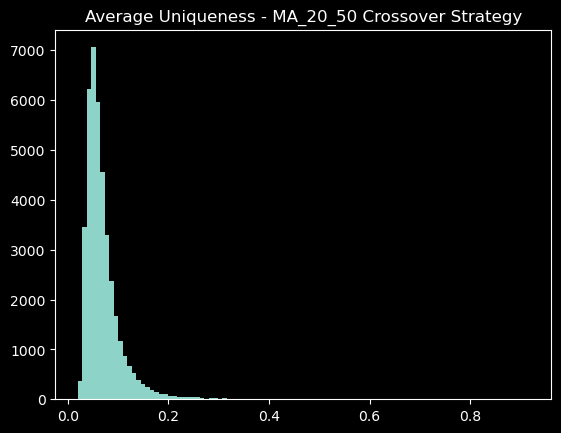

In [66]:
cont_train["tW"].hist(bins=100, grid=False)
plt.title(f"Average Uniqueness - MA_{fast_window}_{slow_window} Crossover Strategy");

In [67]:
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
cv_scores_d = {}
print(clf.__class__.__name__, "Weighting Schemes")

best_scheme = None

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    if scheme.startswith(('linear_time_decay', 'exp_time_decay')):
        if 'exp_time_decay' in scheme:
            continue
        if best_scheme is None:
            best_scheme, best_score = best_weighting_by_mean_score(cv_scores_d, y_train)
        w *= weighting_schemes[best_scheme].values # Combine with best scheme
        scheme = f"{best_scheme}_{scheme}"
            

    print(f"\n{scheme}:")
    cv_scores = ml_cross_val_scores_all(
        clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    cv_scores_d[scheme] = cv_scores
    for scoring, cv_score in cv_scores.items():
        print(f"  {scoring}: μ = {cv_score.mean():.6f}, σ = {cv_score.std():.6f}")


RandomForestClassifier Weighting Schemes

unweighted:
  accuracy: μ = 0.589278, σ = 0.073234
  probability_weighted_accuracy: μ = 0.671619, σ = 0.100701
  neg_log_loss: μ = -0.650337, σ = 0.036663
  precision: μ = 0.297568, σ = 0.025502
  recall: μ = 0.587755, σ = 0.124676
  f1: μ = 0.387687, σ = 0.015056

uniqueness:
  accuracy: μ = 0.633646, σ = 0.068310
  probability_weighted_accuracy: μ = 0.739948, σ = 0.080367
  neg_log_loss: μ = -0.625171, σ = 0.035590
  precision: μ = 0.295819, σ = 0.028923
  recall: μ = 0.530084, σ = 0.108398
  f1: μ = 0.372464, σ = 0.017697

return:
  accuracy: μ = 0.473282, σ = 0.010644
  probability_weighted_accuracy: μ = 0.473363, σ = 0.010807
  neg_log_loss: μ = -0.826179, σ = 0.018366
  precision: μ = 0.473282, σ = 0.010644
  recall: μ = 1.000000, σ = 0.000000
  f1: μ = 0.642416, σ = 0.009850

Best Scheme so far: return with mean f1 score 0.6424

return_linear_time_decay_0.0:
  accuracy: μ = 0.476037, σ = 0.011935
  probability_weighted_accuracy: μ = 0.47

In [68]:
cv_scores_mu_df = pd.DataFrame(index=cv_scores_d.keys()) 
cv_scores_std_df = pd.DataFrame(index=cv_scores_d.keys()) 


for idx, dict_ in cv_scores_d.items():
    for key, val in dict_.items():
        col = key.replace('_score', '').replace('probability_weighted_accuracy', 'PWA')
        cv_scores_mu_df.loc[idx, col] = val.mean()
        cv_scores_std_df.loc[idx, col] = val.std()

print(f"Mean of CV Scores: \n{cv_scores_mu_df}")
print(f"\nStd of CV Scores: \n{cv_scores_std_df}")        

Mean of CV Scores: 
                               accuracy       PWA  neg_log_loss  precision  \
unweighted                     0.589278  0.671619     -0.650337   0.297568   
uniqueness                     0.633646  0.739948     -0.625171   0.295819   
return                         0.473282  0.473363     -0.826179   0.473282   
return_linear_time_decay_0.0   0.476037  0.475779     -0.816030   0.476037   
return_linear_time_decay_0.1   0.474688  0.474337     -0.821351   0.474688   
return_linear_time_decay_0.25  0.474016  0.473847     -0.826335   0.474016   
return_linear_time_decay_0.5   0.473582  0.473191     -0.828642   0.473582   
return_linear_time_decay_0.75  0.473386  0.473292     -0.828243   0.473386   
return_linear_time_decay_0.9   0.473316  0.473407     -0.827085   0.473316   

                                 recall        f1  
unweighted                     0.587755  0.387687  
uniqueness                     0.530084  0.372464  
return                         1.000000  0.

In [ ]:
ma_model_results_time[labeling_methods[0]].keys()

dict_keys(['strategy_name', 'primary_metrics', 'meta_metrics', 'primary_returns', 'meta_returns', 'total_primary_signals', 'filtered_signals'])

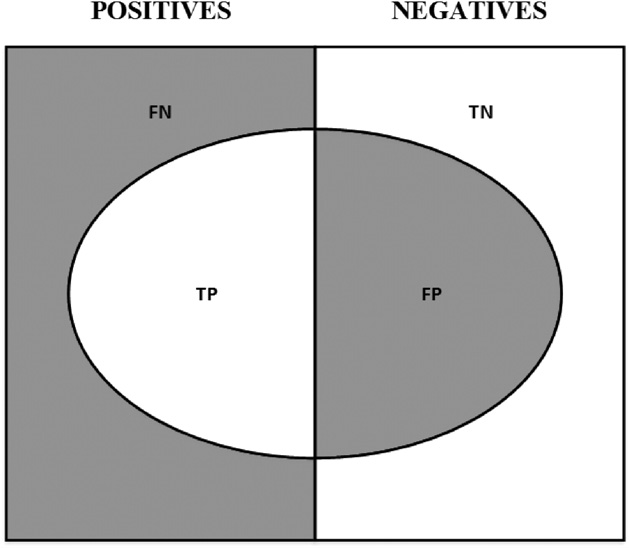

## Measurements Section for Article

- **Accuracy**: Accuracy is the fraction of opportunities correctly labeled by the overlay algorithm,
accuracy = $$\frac{TP + TN}{TP + TN + FP + FN}$$
where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.

- **Precision**: Precision is the fraction of true positives among the predicted positives,
$$precision = \frac{TP}{TP + FP}$$
    
- **Recall**: Recall is the fraction of true positives among the positives,
$$recall = \frac{TP}{TP + FN}$$

- **F1**: Accuracy may not be an adequate classification score for meta-labeling applications. Suppose that, after you apply meta-labeling, there are many more negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a classifier that predicts every case to be negative will achieve high 'accuracy' or 'neg_log_loss', even though it has not learned from the features how to discriminate between cases. In fact, such a model achieves zero recall and undefined precision. The 'f1' score corrects for that performance inflation by scoring the classifier in terms of precision and recall,
$$F1 = 2\frac{precision * recall}{precision + recall}$$

As a side note, consider the unusual scenario where, after applying meta-labeling, there are many more positive cases than negative cases. A classifier that predicts all cases to be positive will achieve TN=0 and FN=0, hence accuracy=precision and recall=1. Accuracy will be high, and F1 will not be smaller than accuracy, even though the classifier is not able to discriminate between the observed samples. One solution would be to switch the definitions of positive and negative cases, so that negative cases are predominant, and then score with F1.


Table 14.1 characterizes the four degenerate cases of binary classification.
As you can see, the F1 score is not defined in two of those cases. For this reason, when Scikit-learn is asked to compute F1 on a sample with no observed 1s or with no predicted 1s, it will print a warning (```UndefinedMetricWarning```), and set the F1 value to 0.

TABLE 14.1 The Four Degenerate Cases of Binary Classification

| Condition | Collapse | Accuracy | Precision | Recall | F1 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Observed all 1s | TN=FP=0 | =recall | 1 | [0,1] | [0,1] |
| Observed all 0s | TP=FN=0 | [0,1] | 0 | NaN | NaN |
| Predicted all 1s | TN=FN=0 | =precision  |[0,1] | 1 | [0,1] |
| Predicted all 0s | TP=FP=0 | [0,1] | NaN | 0 | NaN |

When all observed values are positive (label ‘1’), there are no true negatives or false positives, thus precision is 1, recall is a positive real number between 0 and 1 (inclusive), and accuracy equals recall. Then, $F1 = 2\frac{recall}{1 + recall} \ge recall$.

When all predicted values are positive (label ‘1’), there are no true negatives or false negatives, thus precision is a positive real number between 0 and 1 (inclusive), recall is 1, and accuracy equals precision. Then, $F1 = 2\frac{precision}{1 + precision} \ge precision$.



### 9.4 SCORING AND HYPER-PARAMETER TUNING
Snippets 9.1 and 9.3 set scoring='f1' for meta-labeling applications. For other applications, they set scoring='neg_log_loss' rather than the standard scoring='accuracy'. Although accuracy has a more intuitive interpretation, I suggest that you use neg_log_loss when you are tuning hyper-parameters for an investment strategy. Let me explain my reasoning.
Suppose that your ML investment strategy predicts that you should buy a security, with high probability. You will enter a large long position, as a function of the strategy’s confidence. If the prediction was erroneous, and the market sells off instead, you will lose a lot of money. And yet, accuracy accounts equally for an erroneous buy prediction with high probability and for an erroneous buy prediction with low probability. Moreover, accuracy can offset a miss with high probability with a hit with low probability.
Investment strategies profit from predicting the right label with high confidence. Gains from good predictions with low confidence will not suffice to offset the losses from bad predictions with high confidence. For this reason, accuracy does not provide a realistic scoring of the classifier’s performance. Conversely, log loss (aka cross-entropy loss) computes the log-likelihood of the classifier given the true label, which takes predictions’ probabilities into account. Log loss can be estimated as follows:


$$
L[Y,P] \;=\; -\log \Pr[Y \mid P]
\;=\; -\frac{1}{N}\sum_{n=0}^{N-1}\sum_{k=0}^{K-1} y_{n,k}\,\log p_{n,k}
$$



where
- *p*<sub>n,k</sub> is the probability associated with prediction n of label k.
- *Y* is a 1-of-*K* binary indicator matrix, such that *y*<sub>n,k</sub> = 1 when observation n was
assigned label *k* out of *K* possible labels, and 0 otherwise.

Suppose that a classifier predicts two 1s, where the true labels are 1 and 0. The first prediction is a hit and the second prediction is a miss, thus accuracy is 50%. Figure 9.2 plots the cross-entropy loss when these predictions come from probabilities ranging [0.5, 0.9]. One can observe that on the right side of the figure, log loss is large due to misses with high probability, even though the accuracy is 50% in all cases.
There is a second reason to prefer cross-entropy loss over accuracy. CV scores a classifier by applying sample weights (see Chapter 7, Section 7.5). As you may recall from Chapter 4, observation weights were determined as a function of the observation’s absolute return. The implication is that sample weighted cross-entropy loss estimates the classifier’s performance in terms of variables involved in a PnL (mark-
to-market profit and losses) calculation: It uses the correct label for the side, probability for the position size, and sample weight for the observation’s return/outcome. That is the right ML performance metric for hyper-parameter tuning of financial applications, not accuracy.

When we use log loss as a scoring statistic, we often prefer to change its sign, hence referring to “neg log loss.” The reason for this change is cosmetic, driven by intuition: A high neg log loss value is preferred to a low neg log loss value, just as with accuracy.

$$
L[Y,P] \;=\; -\log \Pr[Y \mid P]
\;=\; -\frac{1}{N}\sum_{n=0}^{N-1}\sum_{k=0}^{K-1} y_{n,k}\,\log p_{n,k}
$$

$$PWA = \frac{\sum_{n=0}^{N-1} y_{n}(p_{n} - K^{-1})}{\sum_{n=0}^{N-1} (p_{n} - K^{-1})}$$



where
- *p*<sub>n,k</sub> is the probability associated with prediction n of label k.
- *Y* is a 1-of-*K* binary indicator matrix, such that *y*<sub>n,k</sub> = 1 when observation n was
assigned label *k* out of *K* possible labels, and 0 otherwise.


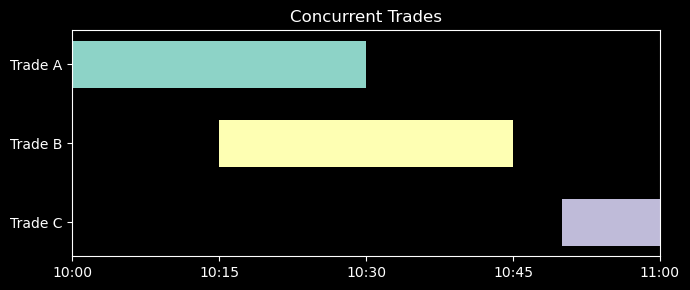

In [87]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_trade_timeline(trades, ticks=None, date_anchor="2025-01-01"):
    """
    trades: list of tuples (label, start_time, end_time) with HH:MM strings
            e.g., [("Trade A", "10:00", "10:30"), ...]
    ticks: optional list of HH:MM strings for exact x-axis ticks
           e.g., ["10:00", "10:15", "10:30", "10:45", "11:00"]
    date_anchor: anchor date to bind all times (YYYY-MM-DD)
    """
    fig, ax = plt.subplots(figsize=(7, 3), dpi=100)

    time_fmt = "%Y-%m-%d %H:%M"
    # Convert HH:MM to anchored datetimes
    def to_dt(t): return datetime.strptime(f"{date_anchor} {t}", time_fmt)

    # Plot bars in list order; we'll invert Y so first is top
    for i, (label, start, end) in enumerate(trades):
        start_dt, end_dt = to_dt(start), to_dt(end)
        ax.barh(
            y=i,
            width=end_dt - start_dt,
            left=start_dt,
            height=0.6,
            align="center",
            label=label
        )

    # Y-axis: labels and order (invert so first trade is at top)
    ax.set_yticks(range(len(trades)))
    ax.set_yticklabels([t[0] for t in trades])
    ax.invert_yaxis()  # ensures Trade A (index 0) is at the top

    # X-axis: exact ticks and formatting
    if ticks is None:
        # Default to min/max derived from trades, rounded to 15 min steps
        ticks = ["10:00", "10:15", "10:30", "10:45", "11:00"]
    tick_dts = [to_dt(t) for t in ticks]
    ax.set_xticks(tick_dts)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    # Limits to the tick range (optional but keeps labels clean)
    ax.set_xlim(tick_dts[0], tick_dts[-1])

    # Styling
    # ax.set_xlabel("Time")
    ax.set_title("Concurrent Trades")
    # Optional: legend on the right
    # ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
    fig.savefig("concurrent_trades.png")
    
    plt.tight_layout()
    plt.show()


# Example usage
trades = [
    ("Trade A", "10:00", "10:30"),
    ("Trade B", "10:15", "10:45"),
    ("Trade C", "10:50", "11:00"),
]
ticks = ["10:00", "10:15", "10:30", "10:45", "11:00"]

plot_trade_timeline(trades, ticks=ticks)


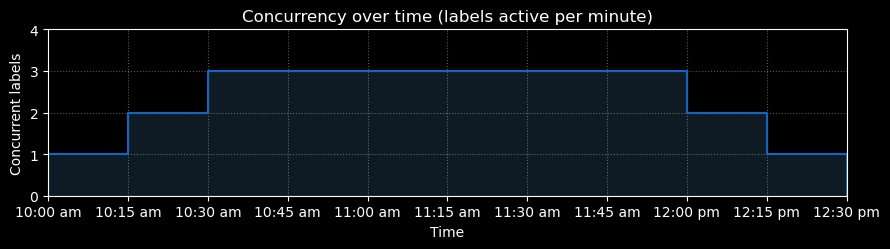

In [84]:
def plot_concurrency_track(signals, hold_minutes=45, date_anchor="2025-01-01", tick_every=15):
    parse = lambda s: datetime.strptime(f"{date_anchor} {s}", "%Y-%m-%d %I:%M %p")
    starts = [parse(s) for s in signals]
    ends = [s + timedelta(minutes=hold_minutes) for s in starts]
    t0, t1 = starts[0], ends[-1]

    # Build minute counts
    minute_counts = {}
    cur = t0.replace(second=0, microsecond=0)
    while cur <= t1:
        minute_counts[cur] = 0
        cur += timedelta(minutes=1)
    for s, e in zip(starts, ends):
        cur = s.replace(second=0, microsecond=0)
        while cur < e:
            minute_counts[cur] += 1
            cur += timedelta(minutes=1)

    # Downsample to ticks for a step plot
    tick_times = []
    tick_vals = []
    cur = t0.replace(second=0, microsecond=0)
    while cur <= t1:
        tick_times.append(cur)
        tick_vals.append(minute_counts.get(cur, 0))
        cur += timedelta(minutes=tick_every)

    fig, ax = plt.subplots(figsize=(9, 2.6))
    ax.step(tick_times, tick_vals, where="post", color="#1565c0")
    ax.fill_between(tick_times, tick_vals, step="post", alpha=0.15, color="#64b5f6")

    ax.set_xticks(tick_times)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%I:%M %p"))
    ax.set_xlim(tick_times[0], tick_times[-1])
    ax.set_ylim(0, max(tick_vals) + 1)

    ax.set_title("Concurrency over time (labels active per minute)")
    ax.set_ylabel("Concurrent labels")
    ax.set_xlabel("Time")
    ax.grid(axis="both", linestyle=":", alpha=0.35)
    plt.tight_layout()
    plt.show()

# Example
plot_concurrency_track(signals, hold_minutes=45)


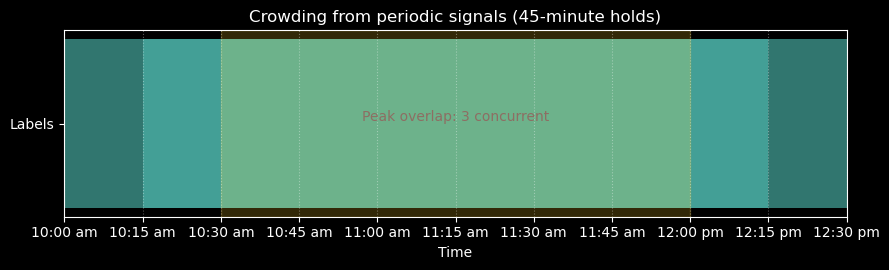

In [80]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from collections import Counter

def plot_crowding_fixed(
    signals,
    hold_minutes=45,
    date_anchor="2025-01-01",
    tick_every=15,
    compact=False,
    figsize=(9, 4)
):
    """
    signals: list of 'HH:MM AM/PM' strings
    hold_minutes: duration of each label
    compact: if True, draw a single-row broken timeline to avoid crowding
    """
    parse = lambda s: datetime.strptime(f"{date_anchor} {s}", "%Y-%m-%d %I:%M %p")
    starts = [parse(s) for s in signals]
    ends = [s + timedelta(minutes=hold_minutes) for s in starts]
    t0, t1 = starts[0], ends[-1]

    # Build x ticks at a fixed grid (e.g., 15 minutes)
    ticks_dt = []
    cur = t0.replace(second=0, microsecond=0)
    while cur <= t1:
        ticks_dt.append(cur)
        cur += timedelta(minutes=tick_every)

    # Minute-resolution concurrency
    # Count number of active trades for each minute
    minute_counts = Counter()
    for s, e in zip(starts, ends):
        cur = s.replace(second=0, microsecond=0)
        while cur < e:
            minute_counts[cur] += 1
            cur += timedelta(minutes=1)

    # Identify true peak band: longest contiguous interval at max concurrency
    if minute_counts:
        max_c = max(minute_counts.values())  # expected 4
        # collect contiguous minute intervals at max_c
        max_minutes = sorted([m for m, c in minute_counts.items() if c == max_c])
        # group into contiguous blocks
        bands = []
        block_start = max_minutes[0]
        for i in range(1, len(max_minutes)):
            if (max_minutes[i] - max_minutes[i-1]) != timedelta(minutes=1):
                bands.append((block_start, max_minutes[i-1]))
                block_start = max_minutes[i]
        bands.append((block_start, max_minutes[-1]))
        # choose the longest block as the peak band
        peak_start, peak_end = max(bands, key=lambda x: x[1] - x[0])
        # widen to tick boundaries for clear annotation
        # snap to nearest quarter-hour
        def snap_down(dt):
            m = (dt.minute // 15) * 15
            return dt.replace(minute=m, second=0, microsecond=0)
        def snap_up(dt):
            m = ((dt.minute + 14) // 15) * 15
            return dt.replace(minute=(m % 60), second=0, microsecond=0) + timedelta(hours=(dt.minute + 14) // 60)
        band_start = snap_down(peak_start)
        band_end = snap_up(peak_end + timedelta(minutes=1))
    else:
        max_c, band_start, band_end = 0, None, None

    fig, ax = plt.subplots(figsize=figsize)

    if compact:
        # Single-row broken timeline to avoid vertical crowding
        # Use broken_barh with segments for each trade
        spans = [(s, (e - s)) for s, e in zip(starts, ends)]
        # matplotlib's broken_barh expects numeric; use dates with barh instead
        # So emulate broken look by drawing semi-transparent bars all on y=0
        for s, e in zip(starts, ends):
            ax.barh(
                y=0, left=s, width=e - s, height=0.8,
                color="#4db6ac", alpha=0.65, edgecolor="none"
            )
        ax.set_yticks([0])
        ax.set_yticklabels(["Labels"])
    else:
        # Full timeline with one row per signal
        for i, (s, e) in enumerate(zip(starts, ends)):
            ax.barh(
                y=i, left=s, width=e - s, height=0.6,
                color="#4db6ac", edgecolor="none"
            )
        ax.set_yticks(range(len(signals)))
        ax.set_yticklabels(signals)
        ax.invert_yaxis()

    # Exact peak band overlay
    if band_start and band_end and max_c > 0:
        ax.axvspan(band_start, band_end, color="#ffca28", alpha=0.2)
        ax.text(
            band_start + (band_end - band_start)/2,
            (0 if compact else -0.6),
            f"Peak overlap: {max_c} concurrent",
            ha="center", va="bottom", fontsize=10, color="#8d6e63"
        )

    ax.set_xticks(ticks_dt)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%I:%M %p"))
    ax.set_xlim(ticks_dt[0], ticks_dt[-1])

    ax.set_title("Crowding from periodic signals (45-minute holds)")
    ax.set_xlabel("Time")
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    plt.tight_layout()
    plt.show()


# Example
signals = [
    "10:00 AM", "10:15 AM", "10:30 AM", "10:45 AM",
    "11:00 AM", "11:15 AM", "11:30 AM", "11:45 AM",
]
plot_crowding_fixed(signals, hold_minutes=45, compact=True, figsize=(9, 2.8))


In [ ]:
linear_plt, exp_plt = [], []
for decay, decay_w in time_decay_weights.items():
    if decay.startswith('linear'):
        linear_plt.append(decay_w)
    else:
        exp_plt.append(decay_w)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 5), sharey=True, dpi=100)
for w in linear_plt:
    ax1.plot(w, alpha=0.7)
for w in exp_plt:
    ax2.plot(w, alpha=0.7)

ax1.set_title('Linear')
ax2.set_title('Exponential')


import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# ax1 and ax2 are your two axes (left/right)
axes = [ax1, ax2]

for ax in axes:
    # show one tick per year on the major axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    # format the major ticks as four-digit years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # optionally remove minor ticks
    # ax.xaxis.set_minor_locator(mdates.NullLocator())
    # tighten the view and improve spacing
    ax.set_xlim(pd.to_datetime(sample_start), pd.to_datetime(cont_train.t1.max()))
    ax.tick_params(axis='x', which='major', rotation=0, labelsize=10)

fig.suptitle("Time-Decay Factors")
fig.subplots_adjust(top=0.88)
plt.tight_layout();


fig.savefig("time_decay_factors.png")


### **Key Insights from the Results**

The experimental results reveal a nuanced and strategy-dependent picture of how sample weighting impacts model performance. The effectiveness of each weighting method varies significantly based on the underlying trading logic.

#### **1. Uniqueness Weighting: A Robust Default for Meta-Labeling**
The **uniqueness weighting** method demonstrated consistent and meaningful improvements across both strategies, establishing itself as a robust default choice.
*   **Bollinger Bands Strategy:** Uniqueness weighting delivered a well-rounded performance boost. Accuracy improved from 56.4% to 58.4%, but more importantly, the **F1 score saw a substantial 6.7% increase** (from 0.622 to 0.663). This indicates a superior balance between precision and recall, meaning the model became better at filtering out false signals while capturing true opportunities. The improvement in probability-weighted accuracy further confirms that the model's confidence became better calibrated on unique, non-redundant examples.
*   **MA Crossover Strategy:** The benefits were even more pronounced. Uniqueness weighting led to a **7.5% increase in accuracy** (58.9% to 63.4%) and a remarkable **10.2% boost in probability-weighted accuracy** (67.2% to 74.0%). While the F1 score saw a slight dip, the dramatic gains in confidence-weighted metrics are critical for a meta-labeling model, where the goal is to size positions based on the probability of a primary signal's success.

#### **2. Return Attribution Weighting: A Cautionary Tale**
In stark contrast to the success of uniqueness weighting, the **return attribution method** produced extreme and undesirable outcomes, highlighting a critical pitfall.
*   **Bollinger Bands Strategy:** The model collapsed into a trivial classifier. Precision, recall, and F1 score all dropped to zero, while accuracy paradoxically jumped to 69.3%. This pattern is a classic sign of a model that has learned to always predict the majority class (likely `0`, or "do not take the trade"). It overfitted to the magnitude of past returns, completely losing its predictive power for the classification task.
*   **MA Crossover Strategy:** A similar, though slightly different, failure mode occurred. The model achieved a perfect recall of 1.0 and a 64.2% F1 score, but with an accuracy of only 47.3%. This suggests the model learned to predict the positive class (`1`, or "take the trade") almost indiscriminately, capturing all true positives but also generating a massive number of false positives. This behavior is untenable for a live trading system.

The failure of return attribution underscores that **concurrency and return magnitude are distinct concepts**. Weighting by returns alone corrupts the learning signal, causing the model to chase past profits rather than learn generalizable patterns from unique informational events.

#### **3. The Pervasiveness of the Concurrency Problem**
The significant performance gains from uniqueness weighting on both a mean-reversion (Bollinger Bands) and a trend-following (MA Crossover) strategy provide strong evidence that **label concurrency is a universal challenge in financial ML**. It is not an edge case but a fundamental data leakage problem that biases models regardless of the core strategy's logic. Addressing it is not optional for robust model development.

### **Conclusion**

This article has tackled one of the most insidious problems in financial machine learning: the violation of the IID assumption due to label concurrency. Our experimental results deliver a clear and actionable verdict: **sample weighting based on temporal uniqueness is a powerful and necessary technique for building robust meta-labeling classifiers, while weighting by return attribution is a dangerous distraction.**

The uniqueness weighting method consistently improved model performance by ensuring that each observation's influence during training was proportional to its unique information content. For the Bollinger Bands strategy, it enhanced the precision-recall balance (F1 score). For the MA Crossover strategy, it significantly boosted both standard and probability-weighted accuracy. In both cases, it steered the model away from learning spurious patterns from temporally redundant data.

Conversely, the dramatic failure of return attribution weighting serves as a critical warning. It demonstrates that conflating an observation's informational uniqueness with its financial return leads to pathological model behavior, either causing total predictive collapse or encouraging reckless over-trading.

For the practitioner, these findings translate into a clear mandate:
1.  **Always Account for Concurrency:** The IID assumption is fundamentally flawed for financial time series. Ignoring label concurrency will lead to overfit models and live trading losses.
2.  **Implement Uniqueness Weighting:** The method outlined here, which calculates the average uniqueness of each triple-barrier label, is a tractable and highly effective solution. It should be a standard component of any financial ML pipeline.
3.  **Avoid Naive Return Weighting:** Do not use absolute returns as sample weights for classification models. While returns are crucial for evaluating strategy performance, they are a misleading proxy for an observation's value during training.
4.  **Validate with the Right Metrics:** As shown, accuracy alone can be deceptive. A combination of log-loss, F1 score, and probability-weighted accuracy is essential to properly diagnose a model's performance and calibration.

By adopting sample weighting based on temporal uniqueness, we move from training models on a distorted, redundant view of the market to training them on a dataset that reflects the true frequency and independence of informational events. This is a foundational step toward developing machine learning models that generalize beyond the backtest and succeed in the adaptive, non-IID reality of financial markets.

In the next article of this series, we will take this a step further by exploring **Sequential Bootstrapping**—a more advanced sampling technique that actively prevents overlapping observations from appearing in the same training set, thereby addressing the root of the concurrency problem during the data resampling stage itself.